# Oblique Decision Trees on Test Shapes

This notebook demonstrates the following:
  1) Load or generate test shape data (for example, 2D shapes).
  2) Compare various oblique decision tree algorithms via K-fold CV.
  3) Select the best performing tree.

In [12]:
import sys
import json
from src.compare_oblique_trees import compare_oblique_trees_kfold
from src.load_shapes import load_all_shape_datasets
from TAO import tao_optimize
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("..")  # Go one folder up to access 'src/'

In [13]:
# -------------------------------
# Utility functions for evaluation
# -------------------------------

def compute_accuracy(tree, X, y):
    """Compute the 0/1 accuracy using the tree's predict method."""
    preds = tree.predict(X)
    return np.mean(preds == y)

def count_nodes(node):
    """Recursively count the number of nodes in the tree.
       Assumes each internal node has attributes 'is_leaf', 'LChild', and 'RChild'."""
    if node is None:
        return 0
    if hasattr(node, "is_leaf") and node.is_leaf:
        return 1
    else:
        return 1 + count_nodes(node.LChild) + count_nodes(node.RChild)

def compute_depth(node):
    """Recursively compute the depth (max root-to-leaf path length) of the tree."""
    if node is None or (hasattr(node, "is_leaf") and node.is_leaf):
        return 0
    else:
        return 1 + max(compute_depth(node.LChild), compute_depth(node.RChild))

def print_tree_stats(name, tree, X, y):
    """
    Compute and print accuracy, number of nodes, and depth for the given tree.
    If the tree has a 'root_node' attribute, use that for node-level statistics.
    Returns a tuple: (accuracy, number_of_nodes, depth)
    """
    # Assume compute_accuracy, count_nodes, compute_depth are available from your TAO module.
    acc = compute_accuracy(tree, X, y)
    node = tree.root_node if hasattr(tree, "root_node") else tree
    nodes = count_nodes(node)
    depth = compute_depth(node)
    print(f"{name} tree:")
    print(f"  Accuracy: {acc*100:.2f}%")
    print(f"  Number of nodes: {nodes}")
    print(f"  Depth: {depth}\n")
    return (acc, nodes, depth)

def run_tao_for_params(base_tree, X, y, min_samples, purity_threshold, lambda_reg,
                       num_passes=3, learning_rate=0.05, num_iter=30):
    """
    Deep-copies base_tree, runs TAO with the specified pruning/regularization parameters,
    prints tree stats, and returns (accuracy, node_count, depth).
    """
    tree_copy = copy.deepcopy(base_tree)
    # Run TAO with additional parameters.
    optimized_tree = tao_optimize(tree_copy, X, y,
                                  num_passes=num_passes,
                                  learning_rate=learning_rate,
                                  num_iter=num_iter,
                                  min_samples=min_samples,
                                  purity_threshold=purity_threshold,
                                  lambda_reg=lambda_reg)
    # Capture stats.
    acc, nodes, depth = print_tree_stats("TAO-optimized", optimized_tree, X, y)
    return acc, nodes, depth

In [14]:
# -------------------------------
# Load the dataset and initial tree.
# -------------------------------
datasets = load_all_shape_datasets()

Starting CSV file loading process from 'data/shapes'...
Data directory set to: ..\data\shapes
Loaded 'barbell_2d_x.csv' as 'barbell_2d_x' with shape (5000, 2)
Loaded 'barbell_2d_y.csv' as 'barbell_2d_y' with shape (5000, 1)
Loaded 'barbell_3d_x.csv' as 'barbell_3d_x' with shape (10000, 3)
Loaded 'barbell_3d_y.csv' as 'barbell_3d_y' with shape (10000, 1)
Loaded 'radial_segment_2d_x.csv' as 'radial_segment_2d_x' with shape (5000, 2)
Loaded 'radial_segment_2d_y.csv' as 'radial_segment_2d_y' with shape (5000, 1)
Loaded 'radial_segment_3d_x.csv' as 'radial_segment_3d_x' with shape (10000, 3)
Loaded 'radial_segment_3d_y.csv' as 'radial_segment_3d_y' with shape (10000, 1)
Loaded 'saddle_3d_x.csv' as 'saddle_3d_x' with shape (10000, 3)
Loaded 'saddle_3d_y.csv' as 'saddle_3d_y' with shape (10000, 1)
Loaded 'sine_wave_2d_x.csv' as 'sine_wave_2d_x' with shape (5000, 2)
Loaded 'sine_wave_2d_y.csv' as 'sine_wave_2d_y' with shape (5000, 1)
Loaded 'square_2d_x.csv' as 'square_2d_x' with shape (10000,

In [15]:
X, y = datasets['square_2d']

methods = ["wodt"]
final_model, best_method, results = compare_oblique_trees_kfold(
    X, y,
    methods=methods,
    n_splits=5,
    max_depth=5,
    n_estimators=1
)


Starting K-Fold cross-validation comparison...

Evaluating method: wodt
  Fold 1: accuracy = 0.9595
  Fold 2: accuracy = 0.8510
  Fold 3: accuracy = 0.9655
  Fold 4: accuracy = 0.9325
  Fold 5: accuracy = 0.8590
Average accuracy for wodt: 0.9135

=== Summary of K-Fold CV Comparison ===
Method: wodt, Average Accuracy: 0.9135

Best method based on CV: wodt (accuracy: 0.9135)

Retraining the best model (wodt) on the entire dataset...
Final model's accuracy on the full dataset: 0.8440


In [16]:
# Print statistics for the initial tree.
initial_stats = print_tree_stats("Initial", final_model, X, y)
initial_acc, initial_nodes, initial_depth = initial_stats

Initial tree:
  Accuracy: 99.90%
  Number of nodes: 277
  Depth: 19


In [17]:
# Set grid values for aggressive pruning and sparsity regularization.
# min_samples_values = [1, 3, 5, 7, 10]              # Lower values: more aggressive pruning.
# purity_threshold_values = [0.0, 0.02, 0.05, 0.1, 0.15]  # Lower threshold means prune even if very low impurity.
# lambda_reg_values = [0.0, 0.001, 0.005, 0.01]      # ℓ₁ regularization strength.

min_samples_values = [100, 300, 500]              # Lower values: more aggressive pruning.
purity_threshold_values = [0.0, 0.02, 0.05]  # Lower threshold means prune even if very low impurity.
lambda_reg_values = [0.0, 0.001, 0.005]      # ℓ₁ regularization strength.


results_list = []

import copy

def run_tao_for_params(base_tree, X, y, min_samples, purity_threshold, lambda_reg,
                       num_passes=3, learning_rate=0.05, num_iter=30):
    """
    Deep-copies base_tree, runs TAO with the specified parameters,
    prints tree stats, and returns (accuracy, node_count, depth).
    """
    tree_copy = copy.deepcopy(base_tree)
    optimized_tree = tao_optimize(tree_copy, X, y,
                                  num_passes=num_passes,
                                  learning_rate=learning_rate,
                                  num_iter=num_iter,
                                  min_samples=min_samples,
                                  purity_threshold=purity_threshold,
                                  lambda_reg=lambda_reg)
    return print_tree_stats("TAO-optimized", optimized_tree, X, y)

# Grid search over the three parameters.
for lam in lambda_reg_values:
    for min_samples in min_samples_values:
        for purity in purity_threshold_values:
            print(f"\nRunning TAO with min_samples={min_samples}, purity_threshold={purity}, lambda_reg={lam}")
            acc, nodes, depth = run_tao_for_params(final_model, X, y,
                                                   min_samples, purity, lam,
                                                   num_passes=3,
                                                   learning_rate=0.05,
                                                   num_iter=30)
            results_list.append({
                "lambda_reg": lam,
                "min_samples": min_samples,
                "purity_threshold": purity,
                "accuracy": acc,
                "nodes": nodes,
                "depth": depth
            })

df = pd.DataFrame(results_list)
print("\nGrid Search Results:")
print(df)


Running TAO with min_samples=100, purity_threshold=0.0, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1
  Depth: 0


Running TAO with min_samples=100, purity_threshold=0.02, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1
  Depth: 0


Running TAO with min_samples=100, purity_threshold=0.05, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1
  Depth: 0


Running TAO with min_samples=300, purity_threshold=0.0, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1
  Depth: 0


Running TAO with min_samples=300, purity_threshold=0.02, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1
  Depth: 0


Running TAO with min_samples=300, purity_threshold=0.05, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1
  Depth: 0


Running TAO with min_samples=500, purity_threshold=0.0, lambda_reg=0.0
TAO-optimized tree:
  Accuracy: 74.74%
  Number of nodes: 1


In [18]:
# Print statistics for the initial tree.
# For node-level statistics we use final_model.root_node.
print_tree_stats("Initial", final_model, X, y)

# Run TAO optimization on the tree.
optimized_tree = tao_optimize(final_model, X, y, num_passes=3, learning_rate=0.05, num_iter=30)

# Print statistics for the optimized tree.
print_tree_stats("TAO-optimized", optimized_tree, X, y)

Initial tree:
  Accuracy: 99.90%
  Number of nodes: 277
  Depth: 19
TAO-optimized tree:
  Accuracy: 99.90%
  Number of nodes: 277
  Depth: 19


(np.float64(0.999), 277, 19)

# Not Needed

In [19]:
# Select the WO-DT method and run k-fold comparison to obtain the final model.
methods = ["wodt"]
final_model, best_method, results = compare_oblique_trees_kfold(
    X, y,
    methods=methods,
    n_splits=5,
    max_depth=8,
    n_estimators=5  # adjust as needed
)


Starting K-Fold cross-validation comparison...

Evaluating method: wodt
  Fold 1: accuracy = 0.9750
  Fold 2: accuracy = 0.9880
  Fold 3: accuracy = 0.9710
  Fold 4: accuracy = 0.9890
  Fold 5: accuracy = 0.9300
Average accuracy for wodt: 0.9706

=== Summary of K-Fold CV Comparison ===
Method: wodt, Average Accuracy: 0.9706

Best method based on CV: wodt (accuracy: 0.9706)

Retraining the best model (wodt) on the entire dataset...
Final model's accuracy on the full dataset: 0.9687


In [20]:
# Run TAO optimization on the tree.
# The tao_optimize function is expected to update the tree in-place (or return a new tree).
optimized_tree = tao_optimize(final_model, X, y, num_passes=3, learning_rate=0.05, num_iter=30)

Dataset 'barbell_3d' loaded:
X shape: (10000, 3), y shape: (10000,)
Reclassifying points based on model predictions...
Reclassification complete.
Reclassified labels (0 = correct, 1 = misclassified):
(array([0, 1]), array([5968, 4032]))
Extracting tree rules from the final model...
Extracted tree rules:
{
  "depth": 1,
  "samples": 10000,
  "rule": {
    "attrIDs": [
      1,
      0
    ],
    "paras": [
      -7.634771335434838,
      -2.62238900394659
    ],
    "threshold": 0.2614361630084838
  },
  "left": {
    "depth": 2,
    "samples": 10000,
    "rule": {
      "attrIDs": [
        1,
        0
      ],
      "paras": [
        -89.40366323580183,
        -0.4922167575289589
      ],
      "threshold": -20.58142826678247
    },
    "left": {
      "depth": 3,
      "samples": 7737,
      "rule": {
        "attrIDs": [
          1,
          0
        ],
        "paras": [
          -242.74767141627478,
          30.364768476251346
        ],
        "threshold": -172.001247420

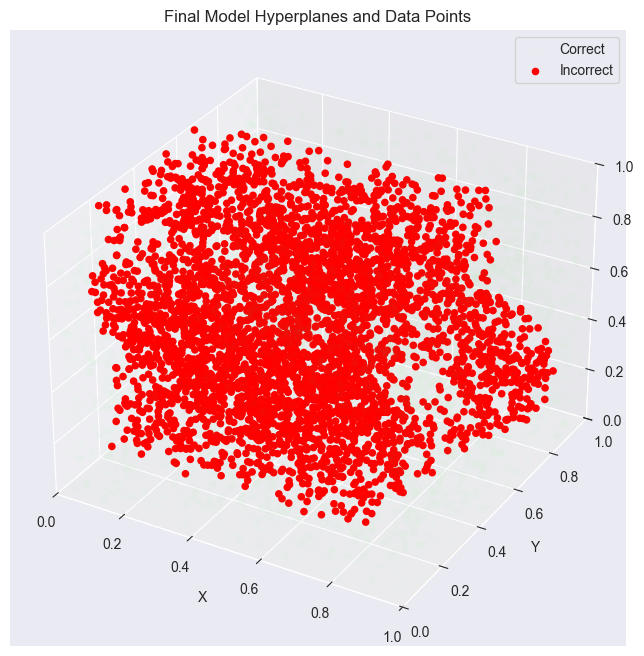

In [22]:
# =============================================================================
# Helper function: reclassify points based on model correctness.
# =============================================================================
def reclassify_points(final_model, points, true_labels):
    """
    Given a trained model, the input points, and the true labels,
    returns a new label array where:
      - 0 indicates the point was classified correctly,
      - 1 indicates the point was misclassified.
    """
    print("Reclassifying points based on model predictions...")
    predictions = final_model.predict(points)
    new_labels = np.where(predictions == true_labels, 0, 1)
    print("Reclassification complete.")
    return new_labels

# =============================================================================
# --- EXTRACT TREE RULES FUNCTION (improved) --------------------
def extract_tree_rules(node):
    """
    Recursively extract the tree's node information into a nested dictionary.
    
    For leaf nodes, returns:
      - 'depth' (if available; otherwise "unknown")
      - 'samples': number of samples (if available)
      - 'rule': a dict with 'label' or 'class_distribution'
    
    For internal nodes, returns:
      - 'depth'
      - 'samples'
      - 'rule': a dict with splitting information (e.g., attrIDs, paras, threshold)
      - 'left': recursively extracted left child information
      - 'right': recursively extracted right child information
    """
    if node is None:
        return None

    depth = getattr(node, "depth", "unknown")
    
    # Try to get the sample count from "samples" or "sample_ids"
    sample_count = None
    if hasattr(node, "samples") and node.samples is not None:
        try:
            sample_count = len(node.samples)
        except Exception:
            sample_count = None
    elif hasattr(node, "sample_ids") and node.sample_ids is not None:
        try:
            sample_count = len(node.sample_ids)
        except Exception:
            sample_count = None

    # For leaf nodes: extract label or class_distribution.
    if hasattr(node, "is_leaf") and node.is_leaf:
        result = {"depth": depth, "samples": sample_count}
        if hasattr(node, "class_distribution"):
            result["rule"] = {"class_distribution": node.class_distribution}
        else:
            result["rule"] = {"label": getattr(node, "value", None)}
        return result

    # For internal nodes, try to extract splitting rule.
    rule = None
    if hasattr(node, "split"):
        split_obj = node.split
        if (hasattr(split_obj, "attrIDs") and hasattr(split_obj, "paras") and 
            hasattr(split_obj, "threshold")):
            rule = {
                "attrIDs": split_obj.attrIDs,
                "paras": split_obj.paras,
                "threshold": split_obj.threshold
            }
    elif hasattr(node, "_weights") and node._weights is not None:
        w = node._weights[:-1]
        threshold = node._weights[-1]
        rule = {"weights": w, "threshold": threshold}
    else:
        rule = "No splitting rule found"

    return {
        "depth": depth,
        "samples": sample_count,
        "rule": rule,
        "left": extract_tree_rules(getattr(node, "LChild", None)),
        "right": extract_tree_rules(getattr(node, "RChild", None))
    }

# =============================================================================
# --- PLOTTING FUNCTIONS --------------------
def plot_tree_hyperplanes_3d(rule_dict, ax, color_map=None):
    """
    Recursively plot the hyperplanes defined by internal nodes in 3D.
    
    For nodes whose 'rule' is a dict with keys "attrIDs", "paras", and "threshold",
    we interpret the hyperplane as: dot(x, w) = threshold.
    
    This function samples a grid over [0,1]x[0,1] and computes corresponding z values.
    If there are fewer than 3 unique valid points, the hyperplane is skipped.
    
    Args:
        rule_dict (dict): Nested dictionary with tree node information.
        ax (Axes3D): The 3D axes to plot on.
        color_map (dict): (Optional) Mapping from node depth to a color.
    """
    if rule_dict is None:
        return

    rule = rule_dict.get("rule", None)
    
    # Plot hyperplane only if a valid splitting rule exists.
    if isinstance(rule, dict) and ("attrIDs" in rule and "paras" in rule and "threshold" in rule):
        indices = rule["attrIDs"]
        coefficients = rule["paras"]
        threshold_val = rule["threshold"]
        
        # Build a full 3D weight vector. Assume dimensions not mentioned are 0.
        w = np.zeros(3)
        for idx, coef in zip(indices, coefficients):
            if idx < 3:
                w[idx] = coef

        if np.abs(w[2]) > 1e-6:
            print(f"Plotting hyperplane at depth {rule_dict.get('depth', 0)}: Equation {w[0]:.2f}x + {w[1]:.2f}y + {w[2]:.2f}z = {threshold_val:.2f}")
            grid_size = 30
            x_lin = np.linspace(0, 1, grid_size)
            y_lin = np.linspace(0, 1, grid_size)
            X_grid, Y_grid = np.meshgrid(x_lin, y_lin)
            Z_grid = (threshold_val - w[0]*X_grid - w[1]*Y_grid) / w[2]
            mask = (Z_grid >= 0) & (Z_grid <= 1)
            X_valid = X_grid[mask]
            Y_valid = Y_grid[mask]
            Z_valid = Z_grid[mask]
            
            # Check if we have at least 3 unique valid points.
            if len(np.unique(np.column_stack((X_valid, Y_valid, Z_valid)), axis=0)) < 3:
                print("  Not enough unique valid points to plot this hyperplane. Skipping.")
            else:
                depth = rule_dict.get("depth", 0)
                color = color_map.get(depth, "blue") if color_map else "blue"
                try:
                    ax.plot_trisurf(X_valid, Y_valid, Z_valid, color=color, alpha=0.4, linewidth=0)
                except Exception as e:
                    print(f"  Warning: Could not plot hyperplane due to error: {e}")
                x_mean, y_mean, z_mean = np.mean(X_valid), np.mean(Y_valid), np.mean(Z_valid)
                formula_str = f"{w[0]:.2f}x + {w[1]:.2f}y + {w[2]:.2f}z = {threshold_val:.2f}"
                ax.text(x_mean, y_mean, z_mean, formula_str, color=color, fontsize=10)

    # Recurse into children if available.
    if "left" in rule_dict and rule_dict["left"] is not None:
        plot_tree_hyperplanes_3d(rule_dict["left"], ax, color_map=color_map)
    if "right" in rule_dict and rule_dict["right"] is not None:
        plot_tree_hyperplanes_3d(rule_dict["right"], ax, color_map=color_map)

def plot_tree_and_points_3d(final_model, points, point_labels=None):
    """
    Plot the final model's hyperplanes (extracted from its tree) in 3D over [0,1]^3 and overlay the data points.
    
    Uses the reclassified point labels to set point transparency:
      - Correctly classified points (new label 0) are shown with alpha=0.01.
      - Misclassified points (new label 1) are shown with alpha=1.0.
    
    Also prints progress messages.
    """
    print("Extracting tree rules from the final model...")
    tree_rules = extract_tree_rules(final_model.root_node)
    print("Extracted tree rules:")
    print(json.dumps(tree_rules, indent=2, default=lambda x: x.tolist() if hasattr(x, 'tolist') else str(x)))
    
    print("Creating 3D plot...")
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title("Final Model Hyperplanes and Data Points")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    
    # Define a colormap mapping depths to colors.
    color_map = {1: "red", 2: "green", 3: "blue", 4: "purple", 5: "orange",
                 6: "cyan", 7: "magenta", 8: "brown", 9: "olive", 10: "pink"}
    
    print("Plotting hyperplanes...")
    plot_tree_hyperplanes_3d(tree_rules, ax, color_map=color_map)
    
    print("Reclassifying data points based on model correctness...")
    if point_labels is not None:
        unique_labels = np.unique(point_labels)
        print(f"Unique reclassified labels: {unique_labels}")
        # Plot points: correctly classified (label 0) will be very faint (alpha=0.01, light green)
        # and misclassified (label 1) will be bright red (alpha=1.0).
        mask_correct = point_labels == 0
        mask_incorrect = point_labels == 1
        print(f"Number of correctly classified points: {np.sum(mask_correct)}")
        print(f"Number of misclassified points: {np.sum(mask_incorrect)}")
        ax.scatter(points[mask_correct, 0], points[mask_correct, 1], points[mask_correct, 2],
                   color="lightgreen", label="Correct", s=20, alpha=0.01)
        ax.scatter(points[mask_incorrect, 0], points[mask_incorrect, 1], points[mask_incorrect, 2],
                   color="red", label="Incorrect", s=20, alpha=1.0)
        ax.legend()
    else:
        print("No point labels provided; plotting all points in gray.")
        ax.scatter(points[:, 0], points[:, 1], points[:, 2], color="gray", s=20)
        
    print("Displaying 3D plot...")
    plt.show()

# =============================================================================
# --- Example usage (for instance, in a Jupyter Notebook in your 2_test_shape_experiments folder) --------------------
if __name__ == '__main__':
    import os
    import pandas as pd

    # Load the "barbell_3d" dataset.
    data_dir = os.path.join("..", "data", "shapes")
    X_df = pd.read_csv(os.path.join(data_dir, "barbell_3d", "barbell_3d_x.csv"))
    y_df = pd.read_csv(os.path.join(data_dir, "barbell_3d", "barbell_3d_y.csv"))
    X = X_df.values  # shape: (n_samples, 3)
    y = y_df.values.squeeze()  # shape: (n_samples,)

    print("Dataset 'barbell_3d' loaded:")
    print(f"X shape: {X.shape}, y shape: {y.shape}")

    # Assume final_model is your trained model.
    reclass_labels = reclassify_points(final_model, X, y)
    print("Reclassified labels (0 = correct, 1 = misclassified):")
    print(np.unique(reclass_labels, return_counts=True))

    # Now plot the hyperplanes and overlay the data points.
    plot_tree_and_points_3d(final_model, X, point_labels=reclass_labels)

Reclassifying points based on model predictions...
Reclassification complete.
Misclassification counts (0 = correct, 1 = misclassified):
(array([0, 1]), array([8440, 1560]))


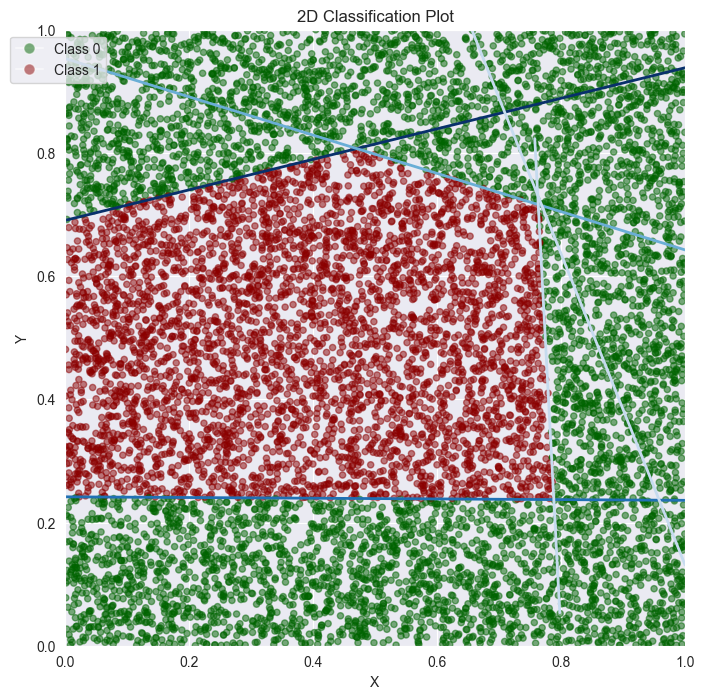

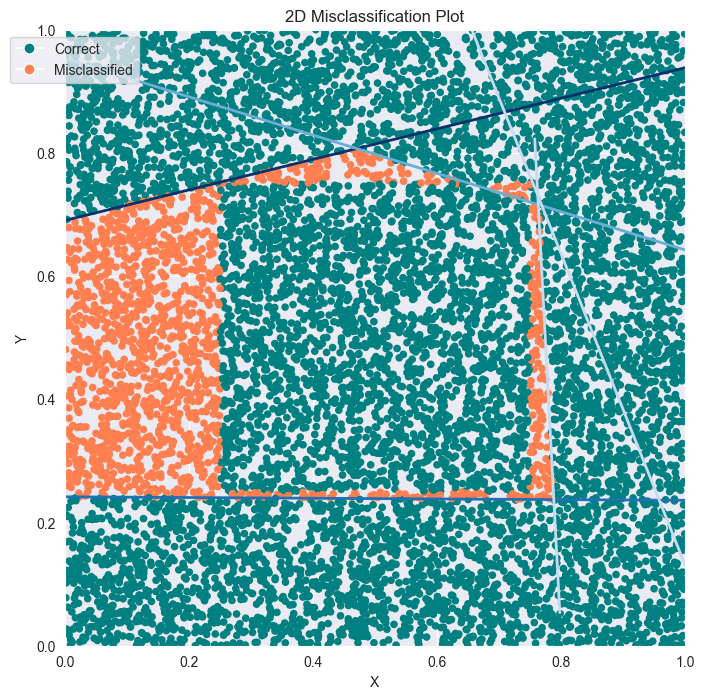

In [16]:
# =============================================================================
# Helper: Reclassify points (0 if correctly classified, 1 if misclassified).
def reclassify_points(final_model, points, true_labels):
    print("Reclassifying points based on model predictions...")
    predictions = final_model.predict(points)
    new_labels = np.where(predictions == true_labels, 0, 1)
    print("Reclassification complete.")
    return new_labels

# Get misclassification labels.
misclass_labels = reclassify_points(final_model, X, y)
print("Misclassification counts (0 = correct, 1 = misclassified):")
print(np.unique(misclass_labels, return_counts=True))

# Get predicted labels from the model for classification plot.
predicted_labels = final_model.predict(X)

# =============================================================================
# 2D Tree Rule Extraction (recursive)
def extract_tree_rules(node):
    if node is None:
        return None

    depth = getattr(node, "depth", "unknown")
    
    sample_count = None
    if hasattr(node, "samples") and node.samples is not None:
        try:
            sample_count = len(node.samples)
        except Exception:
            sample_count = None
    elif hasattr(node, "sample_ids") and node.sample_ids is not None:
        try:
            sample_count = len(node.sample_ids)
        except Exception:
            sample_count = None

    if hasattr(node, "is_leaf") and node.is_leaf:
        result = {"depth": depth, "samples": sample_count}
        if hasattr(node, "class_distribution"):
            result["rule"] = {"class_distribution": node.class_distribution}
        else:
            result["rule"] = {"label": getattr(node, "value", None)}
        return result

    rule = None
    if hasattr(node, "split") and node.split is not None:
        split_obj = node.split
        if (hasattr(split_obj, "attrIDs") and hasattr(split_obj, "paras") and 
            hasattr(split_obj, "threshold")):
            rule = {
                "attrIDs": split_obj.attrIDs,
                "paras": split_obj.paras,
                "threshold": split_obj.threshold
            }
    elif hasattr(node, "_weights") and node._weights is not None:
        w = node._weights[:-1]
        threshold = node._weights[-1]
        rule = {"weights": w, "threshold": threshold}
    else:
        rule = "No splitting rule found"

    return {
        "depth": depth,
        "samples": sample_count,
        "rule": rule,
        "left": extract_tree_rules(getattr(node, "LChild", None)),
        "right": extract_tree_rules(getattr(node, "RChild", None))
    }

# Helper: Find maximum depth in tree rules.
def get_max_depth(rule_dict):
    if rule_dict is None:
        return 0
    current = rule_dict.get("depth", 0)
    left_depth = get_max_depth(rule_dict.get("left"))
    right_depth = get_max_depth(rule_dict.get("right"))
    return max(current, left_depth, right_depth)

# =============================================================================
# 2D Plotting of tree splits using a single-color gradient (Blues)
def plot_tree_lines_2d(rule_dict, ax, cmap, max_depth):
    """
    Recursively plots splitting lines.
    The split is interpreted as: paras[0]*x + paras[1]*y = threshold.
    Each line is colored using the provided "Blues" colormap, where
    shallower nodes appear light blue and deeper nodes appear dark blue.
    """
    if rule_dict is None:
        return

    rule = rule_dict.get("rule", None)
    if isinstance(rule, dict) and ("attrIDs" in rule and "paras" in rule and "threshold" in rule):
        indices = rule["attrIDs"]
        coefficients = rule["paras"]
        threshold_val = rule["threshold"]
        
        # Build a 2D weight vector; features not mentioned are 0.
        w = np.zeros(2)
        for idx, coef in zip(indices, coefficients):
            if idx < 2:
                w[idx] = coef

        depth = rule_dict.get("depth", 1)
        # Normalize depth to [0, 1]: shallower (depth=1) -> light blue, deeper -> dark blue.
        norm_val = 1 - (depth - 1) / (max_depth - 1) if max_depth > 1 else 1.0
        color = cmap(norm_val)
        
        if np.abs(w[1]) > 1e-6:
            x_vals = np.linspace(0, 1, 100)
            y_vals = (threshold_val - w[0] * x_vals) / w[1]
            valid = (y_vals >= 0) & (y_vals <= 1)
            if np.any(valid):
                ax.plot(x_vals[valid], y_vals[valid], color=color, lw=2)
        else:
            if np.abs(w[0]) > 1e-6:
                x_val = threshold_val / w[0]
                if 0 <= x_val <= 1:
                    ax.axvline(x=x_val, color=color, lw=2)
            else:
                print("Warning: Both weights near zero; cannot plot split line.")

    if "left" in rule_dict and rule_dict["left"] is not None:
        plot_tree_lines_2d(rule_dict["left"], ax, cmap, max_depth)
    if "right" in rule_dict and rule_dict["right"] is not None:
        plot_tree_lines_2d(rule_dict["right"], ax, cmap, max_depth)

# =============================================================================
# Plotting function for Classification
def plot_tree_and_points_2d_classification(final_model, points, predicted_labels):
    tree_rules = extract_tree_rules(final_model.root_node)
    max_depth = get_max_depth(tree_rules)
    # print("Extracted tree rules for classification plot:")
    # print(tree_rules)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("2D Classification Plot")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Define colors for predicted classes using a single alpha value.
    class_colors = {0: "darkgreen", 1: "darkred"}
    point_colors = [class_colors[label] for label in predicted_labels]
    ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=20, alpha=0.5)
    
    # Use the "Blues" colormap for tree splits.
    cmap = plt.get_cmap("Blues")
    plot_tree_lines_2d(tree_rules, ax, cmap, max_depth)
    
    # Create proxy artists for the classification legend.
    from matplotlib.lines import Line2D
    proxy_class0 = Line2D([0], [0], marker='o', color='w', label='Class 0',
                           markerfacecolor=class_colors[0], markersize=8, alpha=0.5)
    proxy_class1 = Line2D([0], [0], marker='o', color='w', label='Class 1',
                           markerfacecolor=class_colors[1], markersize=8, alpha=0.5)
    ax.legend(handles=[proxy_class0, proxy_class1], loc='upper left', bbox_to_anchor=(-0.1, 1))
    
    plt.show()

# Plotting function for Misclassification
def plot_tree_and_points_2d_misclassification(final_model, points, misclass_labels):
    tree_rules = extract_tree_rules(final_model.root_node)
    max_depth = get_max_depth(tree_rules)
    # print("Extracted tree rules for misclassification plot:")
    # print(tree_rules)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_title("2D Misclassification Plot")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Define colors: correct = teal, misclassified = coral.
    misclass_colors = {0: "teal", 1: "coral"}
    point_colors = [misclass_colors[label] for label in misclass_labels]
    ax.scatter(points[:, 0], points[:, 1], c=point_colors, s=20)
    
    cmap = plt.get_cmap("Blues")
    plot_tree_lines_2d(tree_rules, ax, cmap, max_depth)
    
    from matplotlib.lines import Line2D
    proxy_correct = Line2D([0], [0], marker='o', color='w', label='Correct',
                           markerfacecolor=misclass_colors[0], markersize=8)
    proxy_misclass = Line2D([0], [0], marker='o', color='w', label='Misclassified',
                           markerfacecolor=misclass_colors[1], markersize=8)
    ax.legend(handles=[proxy_correct, proxy_misclass], loc='upper left', bbox_to_anchor=(-0.1, 1))
    
    plt.show()

# =============================================================================
# Execute both plots.
plot_tree_and_points_2d_classification(final_model, X, predicted_labels)
plot_tree_and_points_2d_misclassification(final_model, X, misclass_labels)